# Job Placement Dataset

Source: https://www.kaggle.com/datasets/ahsan81/job-placement-dataset

This file contains different attribute of the candidates educational history and work experience. The detailed data dictionary is given below:

Data Dictionary
gender : Gender of the candidate  
ssc_percentage : Senior secondary exams percentage (10th Grade)  
ssc_board : Board of education for ssc exams  
hsc_percentage : Higher secondary exams percentage (12th Grade)  
hsc_borad : Board of education for hsc exams  
hsc_subject : Subject of study for hsc  
degree_percentage : Percentage of marks in undergrad degree  
undergrad_degree : Undergrad degree majors  
work_experience : Past work experience  
emp_test_percentage : Aptitude test percentage  
specialization : Postgrad degree majors - (MBA specialization)  
mba_percent : Percentage of marks in MBA degree  
status (TARGET) : Status of placement. Placed / Not Placed

In [567]:
# import packages
import matplotlib as plt
import numpy as np
import pandas as pd
import random
import researchpy as rp
import scipy.stats as stats
import sklearn as sk
from sklearn import discriminant_analysis
from sklearn import linear_model
from sklearn import metrics
from sklearn import neighbors

## Data Exploration

In [568]:
# read data from .csv file
data = pd.read_csv('Job_Placement_Data.csv')

# peek at data
data.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [569]:
# check dimensions of data frame
display(data.shape)

# check data types
display(data.info())

# check for missing values
display(data.isna().sum())

(215, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               215 non-null    object 
 1   ssc_percentage       215 non-null    float64
 2   ssc_board            215 non-null    object 
 3   hsc_percentage       215 non-null    float64
 4   hsc_board            215 non-null    object 
 5   hsc_subject          215 non-null    object 
 6   degree_percentage    215 non-null    float64
 7   undergrad_degree     215 non-null    object 
 8   work_experience      215 non-null    object 
 9   emp_test_percentage  215 non-null    float64
 10  specialisation       215 non-null    object 
 11  mba_percent          215 non-null    float64
 12  status               215 non-null    object 
dtypes: float64(5), object(8)
memory usage: 22.0+ KB


None

gender                 0
ssc_percentage         0
ssc_board              0
hsc_percentage         0
hsc_board              0
hsc_subject            0
degree_percentage      0
undergrad_degree       0
work_experience        0
emp_test_percentage    0
specialisation         0
mba_percent            0
status                 0
dtype: int64

In [570]:
# calculate job placement rate
display(data['status'].value_counts())
np.mean(data['status'] == 'Placed')

Placed        148
Not Placed     67
Name: status, dtype: int64

0.6883720930232559

### Numeric Predictors

In [571]:
# summarize numeric predictors
data.describe()

,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186
std,10.827205,10.897509,7.358743,13.275956,5.833385
min,40.890000,37.000000,50.000000,50.000000,51.210000
25%,60.600000,60.900000,61.000000,60.000000,57.945000
50%,67.000000,65.000000,66.000000,71.000000,62.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000
max,89.400000,97.700000,91.000000,98.000000,77.890000


In [572]:
# likelihood ratio test function from http://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html
def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
    """
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
    
    if features_null:
        features_null = np.array(features_null)
        
        if features_null.shape[1] >= features_alternate.shape[1]:
            raise (ValueError, "Alternate features must have more features than null features")
        
        lr_model.fit(features_null, labels)
        null_prob = lr_model.predict_proba(features_null)[:, 1]
        df = features_alternate.shape[1] - features_null.shape[1]
    else:
        null_prob = sum(labels) / float(labels.shape[0]) * \
                    np.ones(labels.shape)
        df = features_alternate.shape[1]
    
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)

    alt_log_likelihood = -sk.metrics.log_loss(labels,
                                   alt_prob,
                                   normalize=False)
    null_log_likelihood = -sk.metrics.log_loss(labels,
                                    null_prob,
                                    normalize=False)

    G = 2 * (alt_log_likelihood - null_log_likelihood)
    p_value = stats.chi2.sf(G, df)

    return p_value

8.939383353715161e-23

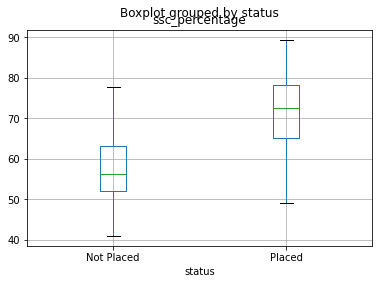

In [573]:
# boxplot factored by status
data.boxplot('ssc_percentage', by = 'status')

# fit logistic regression model on single predictor
logFit = sk.linear_model.LogisticRegression().fit(np.array(data['ssc_percentage']).reshape(-1, 1), data['status'])

# perform likelihood ratio test for independence
likelihood_ratio_test(np.array(data['ssc_percentage']).reshape(-1, 1), (data['status'] == 'Placed').astype(int), logFit)

2.2508006047868448e-15

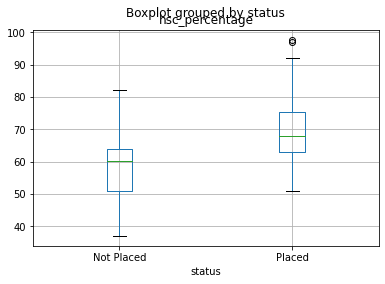

In [574]:
# boxplot factored by status
data.boxplot('hsc_percentage', by = 'status')

# fit logistic regression model on single predictor
logFit = sk.linear_model.LogisticRegression().fit(np.array(data['hsc_percentage']).reshape(-1, 1), data['status'])

# perform likelihood ratio test for independence
likelihood_ratio_test(np.array(data['hsc_percentage']).reshape(-1, 1), (data['status'] == 'Placed').astype(int), logFit)

2.044428524054884e-14

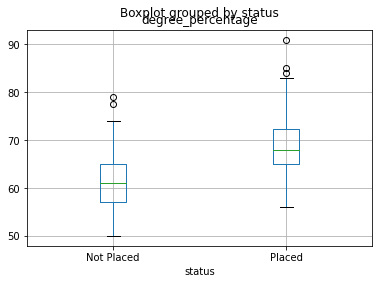

In [575]:
# boxplot factored by status
data.boxplot('degree_percentage', by = 'status')

# fit logistic regression model on single predictor
logFit = sk.linear_model.LogisticRegression().fit(np.array(data['degree_percentage']).reshape(-1, 1), data['status'])

# perform likelihood ratio test for independence
likelihood_ratio_test(np.array(data['degree_percentage']).reshape(-1, 1), (data['status'] == 'Placed').astype(int), logFit)

### Categorical Predictors

In [576]:
# sumamrize categorical predictors
rp.summary_cat(data[['gender', 'ssc_board', 'hsc_board', 'hsc_subject', 'undergrad_degree', 'work_experience', 'specialisation', 'status']])

,Variable,Outcome,Count,Percent
0,gender,M,139,64.65
1,,F,76,35.35
2,ssc_board,Central,116,53.95
3,,Others,99,46.05
4,hsc_board,Others,131,60.93
5,,Central,84,39.07
6,hsc_subject,Commerce,113,52.56
7,,Science,91,42.33
8,,Arts,11,5.12
9,undergrad_degree,Comm&Mgmt,145,67.44


In [577]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['work_experience'])
display(contingency)

# perform chi-squared test for independence
stats.chi2_contingency(contingency)

work_experience,No,Yes
status,,
Not Placed,57,10
Placed,84,64


(15.154425347637423,
 9.906584720516494e-05,
 1,
 array([[43.93953488, 23.06046512],
        [97.06046512, 50.93953488]]))

In [578]:
# construct contingency table
contingency = pd.crosstab(data['status'], data['specialisation'])
display(contingency)

# perform chi-squared test for independence
stats.chi2_contingency(contingency)

specialisation,Mkt&Fin,Mkt&HR
status,,
Not Placed,25,42
Placed,95,53


(12.440229009203623,
 0.00042018425858864284,
 1,
 array([[37.39534884, 29.60465116],
        [82.60465116, 65.39534884]]))

## Model Fitting

In [579]:
# cast binary categorical predictor as numeric
data['work_experience'] = (data['work_experience'] == 'Yes').astype(int)

In [580]:
# set random seed
np.random.seed(2082023)

# number of folds for cross-validation
K = 10

# randomly select folds
folds = np.random.choice(range(K), data.shape[0], replace=True)

# initialize empty array
accuracy = np.zeros([K, 1])

# loop through folds
for fold in range(K - 1):
    # identify training and held-out data
    train_data = data.iloc[np.where(folds != fold)]
    valid_data = data.iloc[np.where(folds == fold)]

    # define training sets
    train_X = train_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
    train_y = train_data['status']

    # define validation sets
    valid_X = valid_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
    valid_y = valid_data['status']

    # fit logistic regression model
    logFit = sk.linear_model.LogisticRegression().fit(train_X, train_y)

    # generate predictions on held-out data
    logPred = logFit.predict(valid_X)

    # calculate predictive accuracy
    accuracy[fold] = np.mean(logPred == valid_y)

# calculate cross-validation predictive accuracy
np.mean(accuracy)


0.7395703686092703

In [581]:
# set random seed
np.random.seed(2082023)

# number of folds for cross-validation
K = 10

# randomly select folds
folds = np.random.choice(range(K), data.shape[0], replace=True)

# initialize empty array
accuracy = np.zeros([K, 1])

# loop through folds
for fold in range(K - 1):
    # identify training and held-out data
    train_data = data.iloc[np.where(folds != fold)]
    valid_data = data.iloc[np.where(folds == fold)]

    # define training sets
    train_X = train_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
    train_y = train_data['status']

    # define validation sets
    valid_X = valid_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
    valid_y = valid_data['status']

    # fit LDA model
    ldaFit = sk.discriminant_analysis.LinearDiscriminantAnalysis().fit(train_X, train_y)

    # generate predictions on held-out data
    ldaPred = ldaFit.predict(valid_X)

    # calculate predictive accuracy
    accuracy[fold] = np.mean(ldaPred == valid_y)

# calculate cross-validation predictive accuracy
np.mean(accuracy)

0.7395703686092703

In [586]:
# define function to help tune K
def CrossValidate(k):
    """
    Given a value for K, calculate classification accuracy for a KNN model using 10-fold cross-validation. 
    """
    # set random seed
    np.random.seed(2082023)

    # number of folds for cross-validation
    K = 10

    # randomly select folds
    folds = np.random.choice(range(K), data.shape[0], replace=True)

    # initialize empty array
    accuracy = np.zeros([K, 1])

    # loop through folds
    for fold in range(K - 1):
        # identify training and held-out data
        train_data = data.iloc[np.where(folds != fold)]
        valid_data = data.iloc[np.where(folds == fold)]

        # define training sets
        train_X = train_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
        train_y = train_data['status']

        # define validation sets
        valid_X = valid_data[['ssc_percentage', 'hsc_percentage', 'degree_percentage', 'work_experience']]
        valid_y = valid_data['status']

        # fit KNN model
        knnFit = sk.neighbors.KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)

        # generate predictions on held-out data
        knnPred = knnFit.predict(valid_X)

        # calculate predictive accuracy
        accuracy[fold] = np.mean(knnPred == valid_y)

    # calculate cross-validation predictive accuracy
    return(np.mean(accuracy))

# intialize data frame for tuning
Ks = np.array([1, 2, 5, 10, 25, 50, 100]).reshape(7, 1)
knnResults = pd.DataFrame(np.concatenate((Ks, np.zeros(7).reshape(7, 1)), axis = 1), columns = ['K', 'Accuracy'])

# tune value of K
for k in Ks:
    # calculate cross-validation accuracy for given K
    knnResults['Accuracy'][np.where(knnResults['K'] == k[0])[0]] = CrossValidate(k[0])

# tuning results
knnResults

,K,Accuracy
0,1.0,0.697608
1,2.0,0.663075
2,5.0,0.738625
3,10.0,0.759272
4,25.0,0.755700
5,50.0,0.740278
6,100.0,0.700083
